## EOF Analysis of 700hPa vorticity

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from intake import open_catalog
import cartopy.io.shapereader as shpreader
import mygrads as mg
#import Ngl
#import Nio
#import fiona
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE
from clim680_function import xyticks

In [2]:
### Read in vorticity anomaly data (non-normalized to be consistent with 680class)
#Non-normalized anomalies
f='/project/xprecip/merra2_ncfiles/winds/winds_morelevels_mean_9-20-22/winds_resampled/vort_anoms_traditional_nonorm.nc'
DS_vort_nonorm=xr.open_dataset(f)
lat_vort=DS_vort_nonorm['lat']
lon_vort=DS_vort_nonorm['lon']
vort_anoms=DS_vort_nonorm['__xarray_dataarray_variable__']
vort_anoms

<xarray.DataArray '__xarray_dataarray_variable__' (time: 3850, lat: 53, lon: 113)>
[23057650 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon        (lon) float64 -126.2 -125.6 -125.0 -124.4 ... -57.5 -56.88 -56.25
  * lat        (lat) float64 24.5 25.0 25.5 26.0 26.5 ... 49.0 49.5 50.0 50.5
    dayofyear  (time) int64 ...

In [3]:
#set any missing values to zero throughout calculation since this will not impact variance
vort_anoms_nonans=vort_anoms.fillna(0)
vort_anoms_nonans

<xarray.DataArray '__xarray_dataarray_variable__' (time: 3850, lat: 53, lon: 113)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  6.76107734e-06,  7.78896974e-06, ...,
          8.32079936e-06,  1.09103005e-05,  0.00000000e+00],
        [ 0.00000000e+00,  6.41076958e-06,  7.89072400e-06, ...,
          3.88280579e-06,  5.90543464e-06,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  1.80647592e-05,  2.84598033e-05, ...,
         -2.66623268e-05, -2.64799682e-05,  0.00000000e+00],
        [ 0.00000000e+00,  2.40219430e-05,  2.24743591e-05, ...,
         -2.57971477e-05, -2.41500425e-05,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.11421567e-05, -1.35595769e-05, ...,
          1.60703297e-05,  2.47753596e-05,  0.00000000e+00],
        [ 0.00000000e+00, -1.17116444e-05, -1.27742428e-05, ...,
          1.26494409e-05,  2.29025933e-05,  0.00000000e+00],
...
        [ 0.00000000e+00,  2.93634294e-05,  4.23770163e-05, ...,
         -7.29942804e-06, -1.75711603e-05,  0.00000000e+00],
        [ 0.00000000e+00,  3.30395023e-05,  3.61045076e-05, ...,
         -1.58355040e-05, -1.20768850e-05,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.14562382e-05,  2.96309941e-06, ...,
          6.78170475e-06,  3.57722611e-06,  0.00000000e+00],
        [ 0.00000000e+00,  1.80594485e-06, -2.83782732e-06, ...,
          6.48257381e-06,  7.59955813e-06,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  2.50862181e-05,  2.94480138e-05, ...,
         -1.92137321e-05, -6.62014410e-06,  0.00000000e+00],
        [ 0.00000000e+00,  1.47142071e-05,  2.93697889e-05, ...,
         -5.61365466e-06, -5.58966684e-06,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon        (lon) float64 -126.2 -125.6 -125.0 -124.4 ... -57.5 -56.88 -56.25
  * lat        (lat) float64 24.5 25.0 25.5 26.0 26.5 ... 49.0 49.5 50.0 50.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 ... 51 52 53 54 55 56 57 58 59

### Weight data

In [4]:
coslat = np.cos(np.deg2rad(vort_anoms_nonans.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
vort_anoms_nonans=vort_anoms_nonans*wgts
wgts.shape

(53, 1)

### Reshape to [time,space]

In [5]:
nx=len(vort_anoms_nonans['lon'])
ny=len(vort_anoms_nonans['lat'])
nt=len(vort_anoms_nonans['time'])

In [6]:
X=np.reshape(vort_anoms_nonans.values,((nt,ny*nx)))
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
X.shape

(3850, 5989)

## Step 2: Calculating the EOF

In [8]:
#calculates the covariance matrix
C=np.cov(X)
C.shape

(3850, 3850)

In [9]:
C

array([[ 4.97623657e-10,  1.28788189e-10,  5.28053853e-11, ...,
        -1.43860359e-10, -8.06767450e-11,  2.84539831e-11],
       [ 1.28788189e-10,  4.48117684e-10,  6.14610717e-11, ...,
        -8.36300399e-11, -5.50868334e-11, -1.95527427e-11],
       [ 5.28053853e-11,  6.14610717e-11,  3.83476868e-10, ...,
        -2.40963446e-11,  2.84409927e-11, -2.24891644e-12],
       ...,
       [-1.43860359e-10, -8.36300399e-11, -2.40963446e-11, ...,
         4.08702580e-10,  5.57359740e-11,  1.42703374e-11],
       [-8.06767450e-11, -5.50868334e-11,  2.84409927e-11, ...,
         5.57359740e-11,  3.57424344e-10,  6.65895559e-11],
       [ 2.84539831e-11, -1.95527427e-11, -2.24891644e-12, ...,
         1.42703374e-11,  6.65895559e-11,  3.65026920e-10]])

In [10]:
#calculates the eigenvectors and eigenvalues of the Covariance Matrix
from numpy import linalg as LA
eigenvalues_v1,eigenvectors_v1=LA.eig(C)

In [11]:
#sort eigenvectors and eigenvalues
eigenvectors_v1.shape


(3850, 3850)

In [12]:
idx = eigenvalues_v1.argsort()[::-1]   
eigenvalues_v1 = eigenvalues_v1[idx]
eigenvectors_v1 = eigenvectors_v1[:,idx]

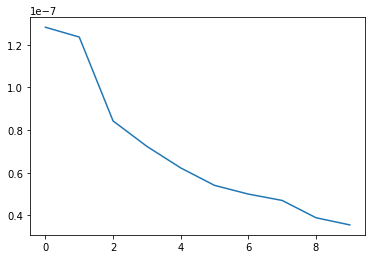

In [13]:
plt.plot(eigenvalues_v1[0:10])

### Get the PC temporal patterns

In [14]:
PC_v1=eigenvectors_v1
PC_v1.shape

(3850, 3850)

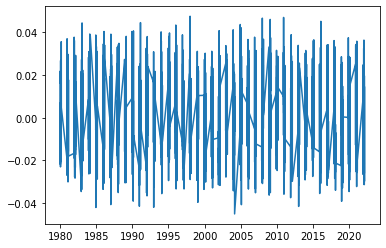

In [15]:
plt.plot(vort_anoms['time'],PC_v1[:,0])

In [16]:
#"it is common practice to divide the PC time series by its standard deviation"
PC_norm=PC_v1/(PC_v1.std(axis=0))
PC_norm

array([[ 1.01198009e+00,  4.29840557e-01,  7.84022544e-01, ...,
        -4.87627172e-01,  2.97950248e-01,  4.55598955e-01],
       [ 5.39941860e-01,  5.46614964e-01,  3.49224894e-01, ...,
        -1.13105924e-01, -2.15794149e-02,  9.08081119e-01],
       [ 9.70329013e-02,  2.70368366e-01,  1.23930024e+00, ...,
        -1.86349122e-01, -1.44499969e+00,  1.36437979e+00],
       ...,
       [-6.47574359e-01,  1.65025869e-01,  2.47917404e-01, ...,
        -1.59072568e+00, -1.83747575e-01, -1.14348283e+00],
       [ 1.09324200e-02, -4.99373001e-01,  3.16530561e-01, ...,
        -1.63570647e+00, -2.26105185e-01, -6.03004827e-01],
       [ 8.85326264e-01,  3.92172862e-01,  7.48884097e-01, ...,
        -8.55045885e-01, -1.30915098e-03, -2.96251460e-01]])

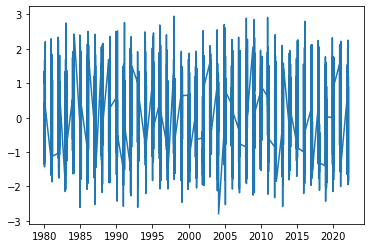

In [17]:
plt.plot(vort_anoms['time'],PC_norm[:,0])

### Get EOF spatial patterns

In [18]:
# Remember to 'unweight' data
EOF_v1=np.dot(X.T,PC_v1)
EOF_v1=EOF_v1.reshape((ny,nx,nt)).T/wgts.squeeze()
EOF_v1.shape

(3850, 113, 53)

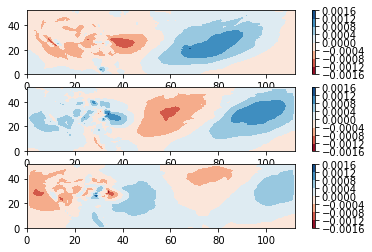

In [19]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(EOF_v1[i,:,:].T,cmap='RdBu')
    plt.colorbar()

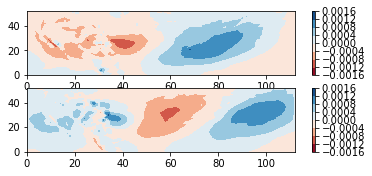

In [20]:
for i in np.arange(2):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(EOF_v1[i,:,:].T,cmap='RdBu')
    plt.colorbar()

In [30]:
diff_EOF=EOF_v1[0,:,:]-EOF_v1[1,:,:]
diff_EOF

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00775604e-04,  8.36456412e-05, ...,
        -2.67492177e-04, -3.86214702e-04,  0.00000000e+00],
       [ 0.00000000e+00,  9.23649021e-05,  7.60577459e-05, ...,
        -2.12461238e-04, -2.67101893e-04,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -3.96541641e-05, -5.12097639e-05, ...,
        -2.61595575e-04, -2.77743261e-04,  0.00000000e+00],
       [ 0.00000000e+00, -1.72109818e-05, -2.77828232e-05, ...,
        -3.17787675e-04, -2.14534186e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

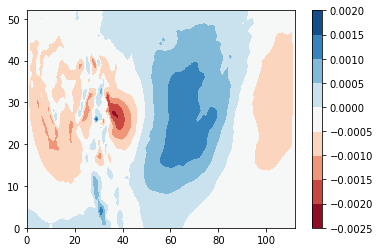

In [31]:
plt.contourf(diff_EOF.T,cmap='RdBu')
plt.colorbar()

### Get the variance explained by each eigenvector

It is the ratio of variance explained by this eigenvector to the total variance

[6.91443459 6.66699069 4.54513223 3.90204288 3.3567992  2.91559664
 2.69497023 2.53434616 2.09716938 1.91525873]


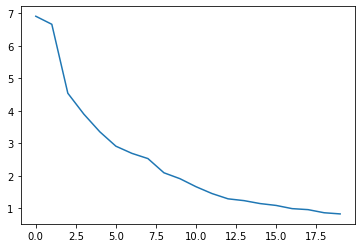

In [26]:
vexp=eigenvalues_v1/np.sum(eigenvalues_v1)
plt.plot(vexp[0:20]*100)
print(vexp[0:10]*100)


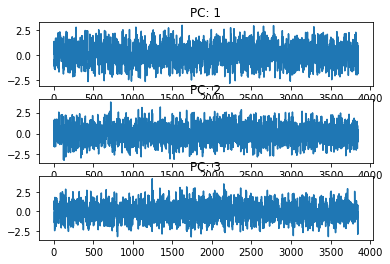

In [22]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=PC_v1[:,i]/np.std(PC_v1[:,i])
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)

Look at first three months;  or first 30 days to see if you can track EOF1 and EOF2 together

### Presenting EOFs

It is common practice to choose a sign convention for our EOFs and multiply the PC timeseries and EOF spatial pattern accordingly.

It is also common practice to divide the PC timeseries by its standard deviation and multiply the EOF spatial pattern by the same. The spatial pattern now has the units of our data (deg C) and the PC time series is in units of standard deviation.



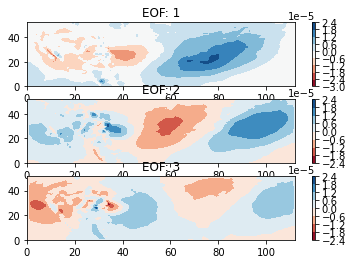

In [24]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    eofnorm=EOF_v1[i,:,:].T*np.std(PC_v1[:,i])
    plt.contourf(eofnorm,cmap='RdBu')
    plt.title('EOF: '+str(i+1))
    plt.colorbar()

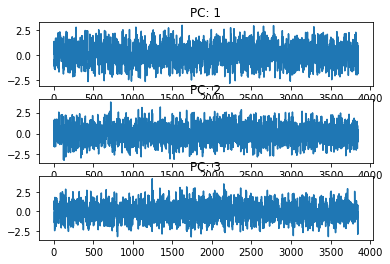

In [25]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)
for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=PC_v1[:,i]/np.std(PC_v1[:,i])
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)

### EOF Analysis with SLP min

In [2]:
f='/project/xprecip/merra2_ncfiles/slp/slp_sixhourly.nc'
DS_slp_6hr=xr.open_dataset(f)
DS_slp_6hr

<xarray.Dataset>
Dimensions:  (lat: 66, lon: 120, time: 61600)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5
Data variables:
    SLP      (time, lat, lon) float32 ...

In [3]:
slp_6hr=DS_slp_6hr['SLP']
slp_6hr

<xarray.DataArray 'SLP' (time: 61600, lat: 66, lon: 120)>
[487872000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2022-02-28T18:00:00
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5

In [4]:
hour0=slp_6hr.isel(time=slp_6hr.time.dt.hour.isin([0]))
hour0

<xarray.DataArray 'SLP' (time: 15400, lat: 66, lon: 120)>
[121968000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5

In [5]:
winter_only_0z=hour0.isel(time=hour0.time.dt.season.isin(['DJF']))
winter_only_0z

<xarray.DataArray 'SLP' (time: 3850, lat: 66, lon: 120)>
[30492000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon      (lon) float64 -127.5 -126.9 -126.2 -125.6 ... -54.38 -53.75 -53.12
  * lat      (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 51.5 52.0 52.5 53.0 53.5

In [6]:
daily_climo_slp=winter_only_0z.groupby('time.dayofyear').mean(dim='time')
daily_climo_slp

<xarray.DataArray 'SLP' (dayofyear: 92, lat: 66, lon: 120)>
array([[[101813.12 , 101810.734, 101808.48 , ..., 101969.   ,
         101966.72 , 101963.9  ],
        [101845.734, 101842.625, 101840.195, ..., 101999.24 ,
         101996.24 , 101992.76 ],
        [101876.62 , 101873.74 , 101871.195, ..., 102027.72 ,
         102024.33 , 102020.945],
        ...,
        [101261.   , 101244.336, 101207.02 , ..., 100340.09 ,
         100286.055, 100237.86 ],
        [101236.41 , 101229.59 , 101240.1  , ..., 100283.52 ,
         100228.71 , 100181.12 ],
        [101177.625, 101222.26 , 101280.22 , ..., 100230.71 ,
         100175.42 , 100126.98 ]],

       [[101789.64 , 101788.99 , 101787.72 , ..., 101959.98 ,
         101958.65 , 101957.24 ],
        [101820.38 , 101818.625, 101816.38 , ..., 101991.49 ,
         101989.57 , 101987.49 ],
        [101849.9  , 101847.76 , 101845.5  , ..., 102021.305,
         102019.836, 102017.125],
...
        [101236.02 , 101207.23 , 101175.79 , ..., 100342.84 ,
         100294.27 , 100246.29 ],
        [101216.94 , 101207.07 , 101219.38 , ..., 100338.14 ,
         100285.21 , 100235.   ],
        [101162.27 , 101212.13 , 101275.07 , ..., 100322.836,
         100268.34 , 100217.12 ]],

       [[101910.52 , 101905.66 , 101901.63 , ..., 101854.22 ,
         101857.3  , 101860.05 ],
        [101948.77 , 101943.57 , 101937.38 , ..., 101883.25 ,
         101885.78 , 101887.35 ],
        [101983.16 , 101976.5  , 101970.63 , ..., 101909.18 ,
         101911.67 , 101914.95 ],
        ...,
        [101200.01 , 101168.48 , 101149.5  , ..., 100161.77 ,
         100146.15 , 100126.42 ],
        [101240.65 , 101238.72 , 101252.32 , ..., 100161.34 ,
         100139.91 , 100110.34 ],
        [101216.49 , 101297.62 , 101380.5  , ..., 100148.25 ,
         100110.99 , 100075.92 ]]], dtype=float32)
Coordinates:
  * lon        (lon) float64 -127.5 -126.9 -126.2 ... -54.38 -53.75 -53.12
  * lat        (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 52.0 52.5 53.0 53.5
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366

In [7]:
slp_anoms=winter_only_0z.groupby('time.dayofyear')-daily_climo_slp
slp_anoms

<xarray.DataArray 'SLP' (time: 3850, lat: 66, lon: 120)>
array([[[-1.24062500e+01, -6.77343750e+00, -6.01562500e-01, ...,
         -2.16039062e+02, -2.13429688e+02, -2.06859375e+02],
        [-1.36093750e+01, -6.41406250e+00,  1.79687500e-01, ...,
         -2.15953125e+02, -2.16617188e+02, -2.10546875e+02],
        [-1.29062500e+01, -6.03125000e+00,  1.51562500e+00, ...,
         -2.23757812e+02, -2.17453125e+02, -2.14406250e+02],
        ...,
        [-8.19242188e+02, -7.85468750e+02, -7.65492188e+02, ...,
         -2.24005469e+03, -2.28176562e+03, -2.28714844e+03],
        [-7.77187500e+02, -7.45007812e+02, -7.29828125e+02, ...,
         -2.17398438e+03, -2.19017188e+03, -2.18257812e+03],
        [-6.75164062e+02, -6.84671875e+02, -6.97531250e+02, ...,
         -2.09042188e+03, -2.07829688e+03, -2.06651562e+03]],

       [[-1.14531250e+01, -8.30468750e+00, -5.94531250e+00, ...,
         -2.29039062e+02, -2.20210938e+02, -2.09304688e+02],
        [-8.44531250e+00, -4.43750000e+00, -1.53125000e+00, ...,
         -2.37968750e+02, -2.30796875e+02, -2.21718750e+02],
        [-3.96093750e+00, -4.84375000e-01,  1.85156250e+00, ...,
         -2.50453125e+02, -2.40234375e+02, -2.32351562e+02],
...
          2.66250000e+01,  4.14218750e+01,  5.96015625e+01],
        [-7.12539062e+02, -7.88507812e+02, -7.72265625e+02, ...,
         -5.16015625e+01, -2.73281250e+01,  1.58593750e+00],
        [-7.41898438e+02, -7.99070312e+02, -7.99242188e+02, ...,
         -1.14617188e+02, -8.12734375e+01, -5.22421875e+01]],

       [[ 3.51093750e+02,  3.46671875e+02,  3.44546875e+02, ...,
          6.02578125e+01,  6.89765625e+01,  7.47656250e+01],
        [ 3.72609375e+02,  3.66445312e+02,  3.63554688e+02, ...,
          7.91093750e+01,  8.56406250e+01,  9.25468750e+01],
        [ 3.92109375e+02,  3.85109375e+02,  3.81664062e+02, ...,
          9.32109375e+01,  1.00140625e+02,  1.10953125e+02],
        ...,
        [-1.68234375e+02, -9.40937500e+01, -6.75468750e+01, ...,
         -8.85734375e+02, -8.30726562e+02, -7.88289062e+02],
        [-9.95937500e+01, -4.72421875e+01, -8.00781250e+00, ...,
         -8.48125000e+02, -7.83554688e+02, -7.38992188e+02],
        [-3.16250000e+01, -3.55781250e+01, -3.18203125e+01, ...,
         -8.08546875e+02, -7.38914062e+02, -6.89554688e+02]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon        (lon) float64 -127.5 -126.9 -126.2 ... -54.38 -53.75 -53.12
  * lat        (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 52.0 52.5 53.0 53.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 ... 51 52 53 54 55 56 57 58 59

In [8]:
hpa_anoms=slp_anoms/100.
hpa_anoms

<xarray.DataArray 'SLP' (time: 3850, lat: 66, lon: 120)>
array([[[-1.2406250e-01, -6.7734376e-02, -6.0156249e-03, ...,
         -2.1603906e+00, -2.1342969e+00, -2.0685937e+00],
        [-1.3609375e-01, -6.4140625e-02,  1.7968750e-03, ...,
         -2.1595314e+00, -2.1661718e+00, -2.1054688e+00],
        [-1.2906250e-01, -6.0312498e-02,  1.5156250e-02, ...,
         -2.2375782e+00, -2.1745312e+00, -2.1440625e+00],
        ...,
        [-8.1924219e+00, -7.8546877e+00, -7.6549220e+00, ...,
         -2.2400547e+01, -2.2817656e+01, -2.2871485e+01],
        [-7.7718749e+00, -7.4500780e+00, -7.2982812e+00, ...,
         -2.1739843e+01, -2.1901718e+01, -2.1825781e+01],
        [-6.7516408e+00, -6.8467188e+00, -6.9753127e+00, ...,
         -2.0904219e+01, -2.0782969e+01, -2.0665155e+01]],

       [[-1.1453125e-01, -8.3046876e-02, -5.9453126e-02, ...,
         -2.2903907e+00, -2.2021093e+00, -2.0930469e+00],
        [-8.4453128e-02, -4.4374999e-02, -1.5312500e-02, ...,
         -2.3796875e+00, -2.3079689e+00, -2.2171874e+00],
        [-3.9609376e-02, -4.8437500e-03,  1.8515624e-02, ...,
         -2.5045311e+00, -2.4023438e+00, -2.3235157e+00],
...
        [-7.1217971e+00, -7.3886719e+00, -8.3182812e+00, ...,
          2.6625001e-01,  4.1421875e-01,  5.9601563e-01],
        [-7.1253905e+00, -7.8850780e+00, -7.7226562e+00, ...,
         -5.1601565e-01, -2.7328125e-01,  1.5859375e-02],
        [-7.4189844e+00, -7.9907031e+00, -7.9924221e+00, ...,
         -1.1461719e+00, -8.1273437e-01, -5.2242190e-01]],

       [[ 3.5109375e+00,  3.4667187e+00,  3.4454687e+00, ...,
          6.0257810e-01,  6.8976563e-01,  7.4765623e-01],
        [ 3.7260938e+00,  3.6644530e+00,  3.6355469e+00, ...,
          7.9109377e-01,  8.5640627e-01,  9.2546874e-01],
        [ 3.9210937e+00,  3.8510938e+00,  3.8166406e+00, ...,
          9.3210936e-01,  1.0014062e+00,  1.1095313e+00],
        ...,
        [-1.6823437e+00, -9.4093752e-01, -6.7546874e-01, ...,
         -8.8573437e+00, -8.3072653e+00, -7.8828907e+00],
        [-9.9593753e-01, -4.7242188e-01, -8.0078125e-02, ...,
         -8.4812498e+00, -7.8355470e+00, -7.3899217e+00],
        [-3.1625000e-01, -3.5578126e-01, -3.1820312e-01, ...,
         -8.0854683e+00, -7.3891406e+00, -6.8955469e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon        (lon) float64 -127.5 -126.9 -126.2 ... -54.38 -53.75 -53.12
  * lat        (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 52.0 52.5 53.0 53.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 ... 51 52 53 54 55 56 57 58 59

In [9]:
#set any missing values to zero throughout calculation since this will not impact variance
slp_anoms_nonans=hpa_anoms.fillna(0)
slp_anoms_nonans

<xarray.DataArray 'SLP' (time: 3850, lat: 66, lon: 120)>
array([[[-1.2406250e-01, -6.7734376e-02, -6.0156249e-03, ...,
         -2.1603906e+00, -2.1342969e+00, -2.0685937e+00],
        [-1.3609375e-01, -6.4140625e-02,  1.7968750e-03, ...,
         -2.1595314e+00, -2.1661718e+00, -2.1054688e+00],
        [-1.2906250e-01, -6.0312498e-02,  1.5156250e-02, ...,
         -2.2375782e+00, -2.1745312e+00, -2.1440625e+00],
        ...,
        [-8.1924219e+00, -7.8546877e+00, -7.6549220e+00, ...,
         -2.2400547e+01, -2.2817656e+01, -2.2871485e+01],
        [-7.7718749e+00, -7.4500780e+00, -7.2982812e+00, ...,
         -2.1739843e+01, -2.1901718e+01, -2.1825781e+01],
        [-6.7516408e+00, -6.8467188e+00, -6.9753127e+00, ...,
         -2.0904219e+01, -2.0782969e+01, -2.0665155e+01]],

       [[-1.1453125e-01, -8.3046876e-02, -5.9453126e-02, ...,
         -2.2903907e+00, -2.2021093e+00, -2.0930469e+00],
        [-8.4453128e-02, -4.4374999e-02, -1.5312500e-02, ...,
         -2.3796875e+00, -2.3079689e+00, -2.2171874e+00],
        [-3.9609376e-02, -4.8437500e-03,  1.8515624e-02, ...,
         -2.5045311e+00, -2.4023438e+00, -2.3235157e+00],
...
        [-7.1217971e+00, -7.3886719e+00, -8.3182812e+00, ...,
          2.6625001e-01,  4.1421875e-01,  5.9601563e-01],
        [-7.1253905e+00, -7.8850780e+00, -7.7226562e+00, ...,
         -5.1601565e-01, -2.7328125e-01,  1.5859375e-02],
        [-7.4189844e+00, -7.9907031e+00, -7.9924221e+00, ...,
         -1.1461719e+00, -8.1273437e-01, -5.2242190e-01]],

       [[ 3.5109375e+00,  3.4667187e+00,  3.4454687e+00, ...,
          6.0257810e-01,  6.8976563e-01,  7.4765623e-01],
        [ 3.7260938e+00,  3.6644530e+00,  3.6355469e+00, ...,
          7.9109377e-01,  8.5640627e-01,  9.2546874e-01],
        [ 3.9210937e+00,  3.8510938e+00,  3.8166406e+00, ...,
          9.3210936e-01,  1.0014062e+00,  1.1095313e+00],
        ...,
        [-1.6823437e+00, -9.4093752e-01, -6.7546874e-01, ...,
         -8.8573437e+00, -8.3072653e+00, -7.8828907e+00],
        [-9.9593753e-01, -4.7242188e-01, -8.0078125e-02, ...,
         -8.4812498e+00, -7.8355470e+00, -7.3899217e+00],
        [-3.1625000e-01, -3.5578126e-01, -3.1820312e-01, ...,
         -8.0854683e+00, -7.3891406e+00, -6.8955469e+00]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon        (lon) float64 -127.5 -126.9 -126.2 ... -54.38 -53.75 -53.12
  * lat        (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 52.0 52.5 53.0 53.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 ... 51 52 53 54 55 56 57 58 59

In [10]:
coslat = np.cos(np.deg2rad(slp_anoms_nonans.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
slp_anoms_nonans=slp_anoms_nonans*wgts
wgts.shape

(66, 1)

In [11]:
nx=len(slp_anoms_nonans['lon'])
ny=len(slp_anoms_nonans['lat'])
nt=len(slp_anoms_nonans['time'])

In [12]:
X=np.reshape(slp_anoms_nonans.values,((nt,ny*nx)))
X

array([[-1.19871627e-01, -6.54462852e-02, -5.81241498e-03, ...,
        -1.61223275e+01, -1.60288136e+01, -1.59379505e+01],
       [-1.10662344e-01, -8.02415240e-02, -5.74447791e-02, ...,
        -6.44588241e+00, -6.84150778e+00, -7.28847016e+00],
       [-2.19965939e-01, -2.06755905e-01, -2.20192402e-01, ...,
         1.95625745e+00,  2.27614440e+00,  2.63399112e+00],
       ...,
       [ 3.17206895e+00,  3.25465056e+00,  3.30613200e+00, ...,
         2.89374498e+00,  2.85530308e+00,  2.70876600e+00],
       [ 4.61551054e+00,  4.68027759e+00,  4.70465939e+00, ...,
        -8.83982293e-01, -6.26819390e-01, -4.02916609e-01],
       [ 3.39233678e+00,  3.34961173e+00,  3.32907955e+00, ...,
        -6.23589763e+00, -5.69885661e+00, -5.31817368e+00]])

In [13]:
X.shape

(3850, 7920)

In [14]:
#calculates the covariance matrix
C=np.cov(X)
C.shape

(3850, 3850)

In [15]:
C

array([[19.31393576, 10.05966836,  9.93169431, ...,  1.86990674,
         2.17768867, 16.75764196],
       [10.05966836, 19.99094289, 13.20578886, ..., -4.55362612,
        -4.75532837,  5.70815287],
       [ 9.93169431, 13.20578886, 37.16401573, ...,  1.05264624,
        -7.6622246 ,  9.67810078],
       ...,
       [ 1.86990674, -4.55362612,  1.05264624, ..., 15.94226842,
         7.73655415,  5.62930929],
       [ 2.17768867, -4.75532837, -7.6622246 , ...,  7.73655415,
        22.26530035,  5.54230941],
       [16.75764196,  5.70815287,  9.67810078, ...,  5.62930929,
         5.54230941, 22.10312387]])

In [16]:
#calculates the eigenvectors and eigenvalues of the Covariance Matrix 
from numpy import linalg as LA
eigenvalues_v1,eigenvectors_v1=LA.eig(C)


In [17]:
#sort eigenvectors and eigenvalues
eigenvectors_v1.shape



(3850, 3850)

In [18]:
idx = eigenvalues_v1.argsort()[::-1]   
eigenvalues_v1 = eigenvalues_v1[idx]
eigenvectors_v1 = eigenvectors_v1[:,idx]

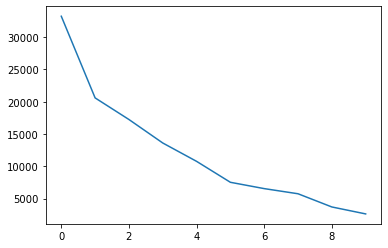

In [19]:
plt.plot(eigenvalues_v1[0:10])

In [20]:
PC_v1=eigenvectors_v1
PC_v1.shape

(3850, 3850)

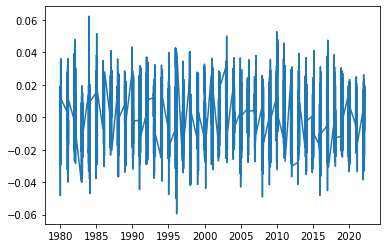

In [21]:
plt.plot(slp_anoms_nonans['time'],PC_v1[:,0])

In [22]:
PC_norm=PC_v1/(PC_v1.std(axis=0))
PC_norm

array([[ 1.01231480e+00,  9.80478402e-02,  3.94127873e-01, ...,
         2.03787053e-01, -6.41546682e-03,  1.60526064e-02],
       [ 7.16769993e-01, -7.36992273e-01, -7.19497954e-01, ...,
        -1.21600990e-01, -1.38870864e-02,  6.37351436e-02],
       [ 1.18978816e+00,  4.21212359e-01, -1.24514462e+00, ...,
         5.18765154e-02,  2.83771309e-02, -1.42402717e-03],
       ...,
       [ 2.28134561e-01,  3.10956732e-01,  4.45467494e-01, ...,
         4.53427608e-01, -2.71433027e-02, -2.89063278e-02],
       [ 4.51740433e-02, -5.76183644e-01,  1.13762890e+00, ...,
         4.65133623e-01,  9.22623720e-04,  7.11021007e-02],
       [ 1.18476009e+00,  2.24551925e-01,  7.44118907e-01, ...,
        -6.99490808e-01,  4.00276100e-02, -7.09552220e-03]])

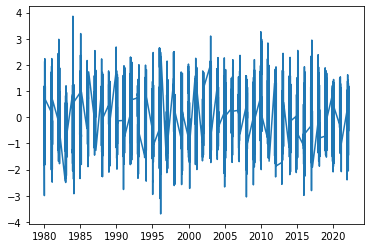

In [23]:
plt.plot(slp_anoms_nonans['time'],PC_norm[:,0])

### Get EOF spatial patterns

In [24]:
# Remember to 'unweight' data
EOF_v1=np.dot(X.T,PC_v1)
EOF_v1=EOF_v1.reshape((ny,nx,nt)).T/wgts.squeeze()
EOF_v1.shape

(3850, 120, 66)

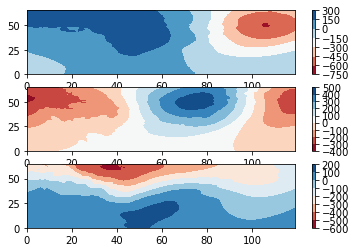

In [25]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(EOF_v1[i,:,:].T,cmap='RdBu')
    plt.colorbar()

In [26]:
# 2nd plot: 'tripole pattern'. 
# 3rd plot: north-south dipole

[23.71149609 14.68855954 12.301533    9.70655203  7.67827235  5.36328457
  4.66504052  4.09584109  2.63739513  1.86889824]


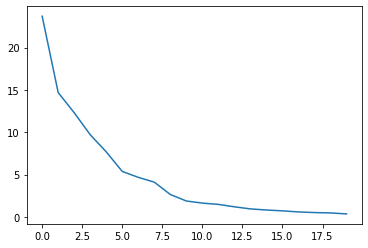

In [27]:
### Variance explained by each eigenvector
vexp=eigenvalues_v1/np.sum(eigenvalues_v1)
plt.plot(vexp[0:20]*100)
print(vexp[0:10]*100)


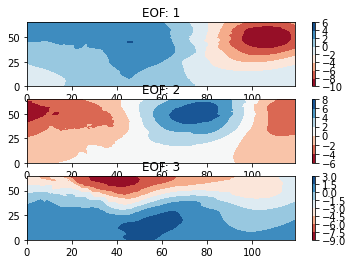

In [28]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    eofnorm=EOF_v1[i,:,:].T*np.std(PC_v1[:,i])
    plt.contourf(eofnorm,cmap='RdBu')
    plt.title('EOF: '+str(i+1))
    plt.colorbar()

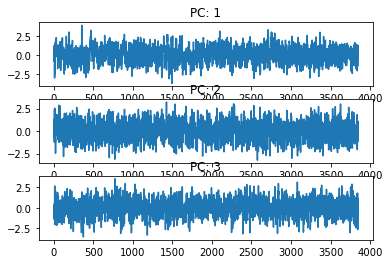

In [29]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)
for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=PC_v1[:,i]/np.std(PC_v1[:,i])
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)

### Splitting spatial domain in half to see if pattern shifts

In [30]:
#set any missing values to zero throughout calculation since this will not impact variance
slp_subset=slp_anoms_nonans.sel(lon=slice(-97,-71))
slp_subset

<xarray.DataArray 'SLP' (time: 3850, lat: 66, lon: 42)>
array([[[  4.85230981,   4.66065097,   4.34972449, ...,  -3.46389751,
          -3.52564493,  -3.71126476],
        [  4.8796525 ,   4.71288535,   4.4826665 , ...,  -3.81032324,
          -3.87716569,  -3.94250089],
        [  5.03816865,   4.86484612,   4.62810694, ...,  -4.28717919,
          -4.1875036 ,  -4.19600427],
        ...,
        [ -0.69263844,  -0.75298449,  -0.79583627, ...,  -3.04150147,
          -3.15542731,  -3.39803088],
        [ -0.52855213,  -0.60091669,  -0.67467519, ...,  -3.0494931 ,
          -3.07628121,  -3.15391872],
        [ -0.22914487,  -0.27933623,  -0.32482778, ...,  -2.97177343,
          -2.99617629,  -3.0649258 ]],

       [[  1.34372466,   1.78456244,   2.03094834, ...,  -4.04604482,
          -4.0516307 ,  -4.15066818],
        [  1.46646543,   1.715448  ,   1.94536501, ...,  -4.36480704,
          -4.44664565,  -4.3825914 ],
        [  1.34204722,   1.66544755,   1.87224624, ...,  -4.53392322,
          -4.53964053,  -4.5380606 ],
...
        [  0.49819012,   0.19847143,  -0.13020116, ..., -11.86842097,
         -11.40765707, -10.73239078],
        [  0.65485678,   0.36503491,   0.11872877, ..., -11.87408912,
         -11.45384159, -11.00232073],
        [  0.75413552,   0.51516926,   0.30422102, ..., -11.96217034,
         -11.54310545, -11.108616  ]],

       [[  8.72647352,   7.62830418,   6.64570421, ...,  -0.38226065,
          -0.44566882,  -0.5112661 ],
        [  8.46902576,   7.66736848,   6.66819744, ...,  -0.43775424,
          -0.4657874 ,  -0.5234362 ],
        [  8.6125733 ,   7.77274047,   6.76259438, ...,  -0.45128597,
          -0.47693833,  -0.53426117],
        ...,
        [  4.84024018,   4.74289427,   4.62378679, ...,  -1.19479064,
          -1.56082902,  -1.84860035],
        [  4.78909082,   4.59223997,   4.4495106 , ...,  -1.68977891,
          -2.04978342,  -2.44669765],
        [  4.64110271,   4.47938158,   4.38038477, ...,  -2.17503867,
          -2.55481783,  -2.95767408]]])
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2022-02-28
  * lon        (lon) float64 -96.88 -96.25 -95.62 -95.0 ... -72.5 -71.88 -71.25
  * lat        (lat) float64 21.0 21.5 22.0 22.5 23.0 ... 52.0 52.5 53.0 53.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 ... 51 52 53 54 55 56 57 58 59

In [31]:
coslat = np.cos(np.deg2rad(slp_subset.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
slp_subset=slp_subset*wgts
wgts.shape

(66, 1)

In [32]:
nx=len(slp_subset['lon'])
ny=len(slp_subset['lat'])
nt=len(slp_subset['time'])

In [33]:
X=np.reshape(slp_subset.values,((nt,ny*nx)))
X

array([[ 4.68839712,  4.50321259,  4.2027893 , ..., -2.29197298,
        -2.31079363, -2.36381652],
       [ 1.29833318,  1.72427931,  1.96234221, ..., -2.11180679,
        -2.03164512, -1.98364098],
       [-6.69719951, -5.61351717, -4.83040369, ..., -0.39741596,
        -0.4023883 , -0.43315181],
       ...,
       [ 6.02560541,  5.2133901 ,  4.79225787, ...,  2.42845705,
         2.56317507,  2.63232324],
       [ 4.74543311,  4.38002407,  4.03678696, ..., -9.22579459,
        -8.90259183, -8.5674929 ],
       [ 8.43169026,  7.37061745,  6.42121004, ..., -1.67749325,
        -1.970397  , -2.28109889]])

In [34]:
X.shape

(3850, 2772)

In [35]:
#calculates the covariance matrix
C=np.cov(X)
C.shape

(3850, 3850)

In [36]:
C

array([[10.45694262,  8.57281795,  2.67410941, ...,  1.84350264,
        -1.93094908,  5.71934065],
       [ 8.57281795, 11.4458739 ,  5.5473957 , ..., -3.0379246 ,
        -4.74855425,  3.94334907],
       [ 2.67410941,  5.5473957 , 15.33976479, ..., -5.27175863,
        -9.76167658,  0.50563051],
       ...,
       [ 1.84350264, -3.0379246 , -5.27175863, ..., 12.728552  ,
        10.19844901,  3.03199836],
       [-1.93094908, -4.74855425, -9.76167658, ..., 10.19844901,
        21.51869475,  1.43327223],
       [ 5.71934065,  3.94334907,  0.50563051, ...,  3.03199836,
         1.43327223,  6.19485818]])

In [37]:
#calculates the eigenvectors and eigenvalues of the Covariance Matrix 
from numpy import linalg as LA
eigenvalues_v1,eigenvectors_v1=LA.eig(C)



In [38]:
eigenvectors_v1.shape

(3850, 3850)

In [39]:
idx = eigenvalues_v1.argsort()[::-1]   
eigenvalues_v1 = eigenvalues_v1[idx]
eigenvectors_v1 = eigenvectors_v1[:,idx]

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


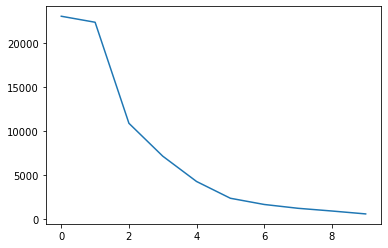

In [40]:
plt.plot(eigenvalues_v1[0:10])

In [41]:
PC_v1=eigenvectors_v1
PC_v1.shape

(3850, 3850)

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


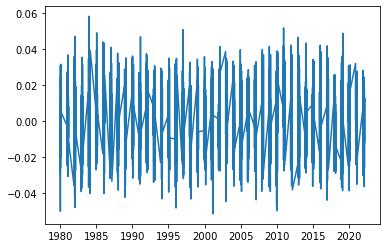

In [42]:
plt.plot(slp_subset['time'],PC_v1[:,0])

In [43]:
PC_norm=PC_v1/(PC_v1.std(axis=0))
PC_norm

array([[ 0.75583921+0.j        ,  0.43134946+0.j        ,
         0.07175158+0.j        , ..., -0.1343878 +0.25547997j,
        -0.1343878 -0.25547997j, -0.62224589+0.j        ],
       [ 0.65129448+0.j        ,  0.40869299+0.j        ,
        -0.65526286+0.j        , ..., -0.01049389+0.14132449j,
        -0.01049389-0.14132449j,  1.6635564 +0.j        ],
       [ 0.25868864+0.j        ,  1.35830035+0.j        ,
        -0.54512888+0.j        , ..., -0.09298636-0.00127684j,
        -0.09298636+0.00127684j,  0.53004998+0.j        ],
       ...,
       [ 0.49553066+0.j        , -0.33192166+0.j        ,
         1.61353432+0.j        , ...,  0.03911236+0.31728359j,
         0.03911236-0.31728359j, -0.18729897+0.j        ],
       [ 0.79069026+0.j        , -1.29410255+0.j        ,
         1.11259461+0.j        , ..., -0.74163643-0.38197747j,
        -0.74163643+0.38197747j,  0.16184612+0.j        ],
       [ 0.66806008+0.j        ,  0.22000718+0.j        ,
         0.45668432+0.j       

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


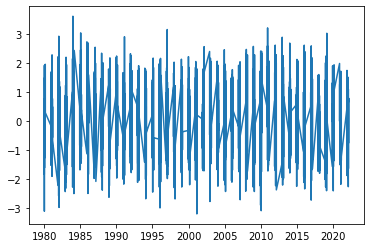

In [44]:
plt.plot(slp_subset['time'],PC_norm[:,0])

In [45]:
# Remember to 'unweight' data
EOF_v1=np.dot(X.T,PC_v1)
EOF_v1=EOF_v1.reshape((ny,nx,nt)).T/wgts.squeeze()
EOF_v1.shape

(3850, 42, 66)

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/ma/core.py:2832: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


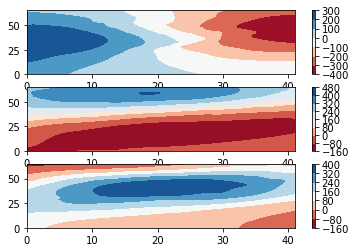

In [46]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(EOF_v1[i,:,:].T,cmap='RdBu')
    plt.colorbar()

[29.8121443 -4.38600200e-32j 28.92650802-4.25570602e-32j
 14.04519442-2.06634753e-32j  9.20603069-1.35440338e-32j
  5.47468756-8.05443255e-33j  3.00478333-4.42067688e-33j
  2.09043809-3.07548010e-33j  1.52762329-2.24745953e-33j
  1.12874957-1.66063126e-33j  0.69943642-1.02902008e-33j]


/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


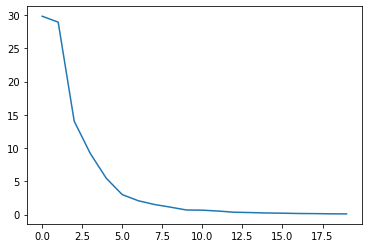

In [47]:
### Variance explained by each eigenvector
vexp=eigenvalues_v1/np.sum(eigenvalues_v1)
plt.plot(vexp[0:20]*100)
print(vexp[0:10]*100)

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/ma/core.py:2832: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


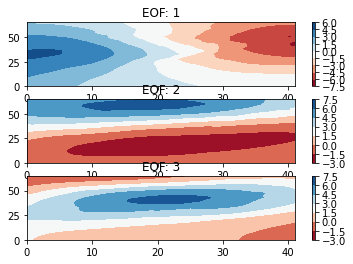

In [48]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    eofnorm=EOF_v1[i,:,:].T*np.std(PC_v1[:,i])
    plt.contourf(eofnorm,cmap='RdBu')
    plt.title('EOF: '+str(i+1))
    plt.colorbar()

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


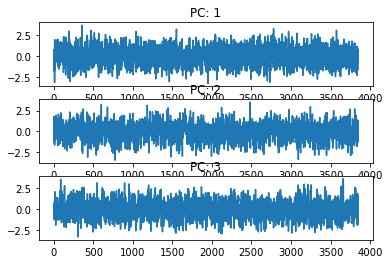

In [49]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)
for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=PC_v1[:,i]/np.std(PC_v1[:,i])
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)

Considering the entire domian of CONUS, an EOF analysis of SLP anomalies indicates that a the most variance explained (23.7%) comes from a east-west dipole pattern, followed by a tripole pattern explaining 14.7% of the variance. The third mode is a North-south dipole, explaining % of the variance. However, when only the eastern half of CONUS is included in the EOF analysis, the east-west dipole pattern and the north-south dipole pattern explain similar percentages of the variance, at % and %, respectively. 